In [103]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%matplotlib inline

import random
import math
import numpy as np

import torch
import torch.nn as nn
from tqdm import tqdm

from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from IPython.display import clear_output
from tqdm.notebook import tqdm as tqdm

from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA

SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

from IPython.display import clear_output
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## **EBM-OT Algorithm**

### **Given:**

- Distributions $p(x)$ and $q(y)$.
- Cost function: $c(x, y)$.
- Parameterized functions: $u_\theta(x)$ and $v_\theta(y)$.

### **Objective:**

Optimize plan $\pi_\theta(x, y)$ minimizing KL-divergence $KL(\pi_\theta | \pi^*)$.

### **Optimization:**

**Repeat** until convergence:

1. **Compute gradient** $\nabla_\theta L$:
$$
\nabla_\theta L = - \nabla_\theta \log z_\theta + \int \nabla_\theta u_\theta(x)d\mathbb{P}(x) +  \int \nabla_\theta v_\theta(y)d\mathbb{Q}(y) - \int (\nabla_\theta u_\theta(x) + \nabla_\theta v_\theta(y))d\pi_\theta(x,y).
$$

2. **Update** $\theta$ using gradient descent (or any optimization algorithm).
    
### **Sampling Using Langevin Dynamics:**

For each dimension $(x, y)$:

1. **Compute partial derivatives** for $\pi_\theta(x, y)$:
$$
\nabla_x \pi_\theta(x, y) = \frac{\partial u(x)}{\partial x} - \frac{\partial c(x, y)}{\partial x}, \quad \nabla_y \pi_\theta(x, y) = \frac{\partial v(y)}{\partial y} - \frac{\partial c(x, y)}{\partial y}.
$$

2. **Update** $(x, y)$ using these gradients via Langevin dynamics.

### **Note:**
- Optimization aims to maximize the likelihood, thus we move in the direction of $-\nabla_\theta L$.



In [104]:
DEVICE

'cuda'

## Datasets

In [105]:
def sample_normal(size=64):
    return np.random.normal(size=(size,2)).astype(np.float32)


def sample_swiss(size=64):
    return make_swiss_roll(
        n_samples=size, noise=0.8
    )[0].astype(np.float32)[:, [0, 2]] / 6.5


def sample_normal(size=64):
    return np.random.normal(size=(size,2)).astype(np.float32)


def sample_swiss(size=64):
    return make_swiss_roll(
        n_samples=size, noise=0.8
    )[0].astype(np.float32)[:, [0, 2]] / 6.5


class GaussianDataset:
    def __init__(self, n_samples):
        """
        Инициализация сэмплера гауссовского распределения 2D.

        :param n_samples: Общее количество генерируемых точек.
        """
        self.n_samples = n_samples

    def sample(self, batch_size=200):
        """
        Генерация выборки из 2D гауссовского распределения.

        :param batch_size: Число генерируемых точек за одно сэмплирование.
        :return: Тензор размером [batch_size, 2].
        """
        sampled_size = min(self.n_samples, batch_size)
        samples = sample_normal(sampled_size)
        return torch.tensor(samples)

class SwissrollDataset:
    def __init__(self, n_samples):
        """
        Инициализация датасета Swiss Roll.

        :param n_samples: Общее количество генерируемых точек.
        """
        self.n_samples = n_samples

    def sample(self, batch_size=200):
        """
        Генерация выборки Swiss Roll и её масштабирование.

        :param batch_size: Число генерируемых точек за одно сэмплирование.
        :return: Тензор размером [batch_size, 2].
        """
        sampled_size = min(self.n_samples, batch_size)
        samples = sample_swiss(sampled_size)
        return torch.tensor(samples)

## Initialization of parameters

In [106]:
class ParamsProxy:
    def __init__(self, params):
        self.params = params

    def __getattr__(self, name):
        if name in self.params:
            return self.params[name]
        else:
            raise AttributeError(f"No such attribute: {name}")


class Config:
    def __init__(self):
        self.params = {
            "N_SAMPLES": 1024,  # number of samples in batch
            "LANGEVIN_STEPS": 150,  # number of steps in langevin dynamic
            "STEP_SIZE": 1.,  # langevin step size
            "SAMPLING_NOISE": 0.04,  # langevin noise variance
            "HREG": 1.,  # entropy regularization (eps)
            "NUM_ITERS": 300,  # number of training epochs
            "HIDDEN_SIZE": 256,  # size of hidden layer
            "LR": 2e-4  # learning rate
        }

    def get_params(self):
        return ParamsProxy(self.params)

    def update_params(self, new_params):
        self.params.update(new_params)


config = Config()
params = config.get_params()

In [107]:
def l2_cost(X, Y):
  return ((X-Y)**2).mean(dim=1)

COST = l2_cost

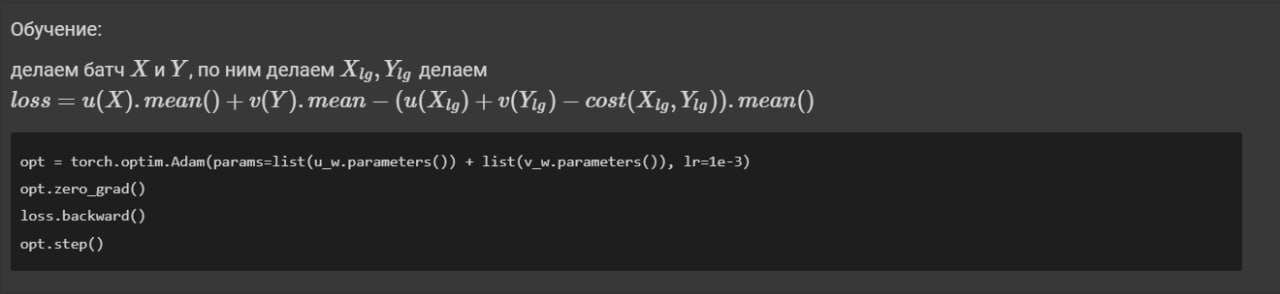

## Derivatives and sampling functions and utilities




In [108]:
def c(x, y):
    return 0.5*torch.pow(torch.norm(x - y), 2)

In [109]:
def fn_grad(value, variable):
    """Calculates the gradient of a given value w.r.t. variable."""
    return torch.autograd.grad(outputs=value, inputs=variable, grad_outputs=torch.ones(value.shape, device=DEVICE), create_graph=True, retain_graph=True)[0]


@torch.enable_grad()
def potential_score(f, x):
    x.requires_grad_(True)
    val = f(x)
    score = fn_grad(val, x)
    return score


@torch.enable_grad()
def cost_score(x, y):
    x.requires_grad_(True)
    coef = params.SAMPLING_NOISE**2/params.HREG
    cost = c(x, y)
    score = fn_grad(cost, x)
    return coef * score

In [110]:
def gradient_fn(value, variable):
    """Calculates the gradient of a given value with respect to a variable."""
    return torch.autograd.grad(outputs=value, inputs=variable, grad_outputs=torch.ones(value.shape, device=DEVICE), create_graph=True)[0]

In [111]:
def langevin_sampling(u_model, v_model, n_samples=params.N_SAMPLES, num_steps=params.LANGEVIN_STEPS, noise_level=params.SAMPLING_NOISE):
    """
    Performs Langevin dynamics sampling.

    Parameters:
    - init_x, init_y: Initial samples for the x and y variables.
    - total_steps: Number of Langevin dynamics steps.
    - noise_level: The standard deviation for the sampling noise.
    - delta: Step size for the dynamics.

    Returns:
    - x_final, y_final: Samples after Langevin dynamics.
    """
    u_model.eval()
    v_model.eval()
    x, y = torch.randn(size=(2*n_samples, 2), device=DEVICE).split(n_samples, dim=0)

    for step in range(num_steps):

        log_p_grad_x = potential_score(u_model, x) - cost_score(x, y)
        log_p_grad_y = potential_score(v_model, y) - cost_score(y, x)

        z = torch.randn_like(x)

        x = x + 0.5 * log_p_grad_x + noise_level * z
        y = y + 0.5 * log_p_grad_y + noise_level * z

    u_model.train()
    v_model.train()

    return x, y

In [112]:
class ReplayBuffer:
    def __init__(self, mean, std, Xs, device='cpu'):
        """
        Инициализация буфера воспроизведения.

        :param mean: Матожидание для нормального распределения.
        :param std: Стандартное отклонение для нормального распределения.
        :param Xs: Начальные сэмплы состояний.
        :param device: Устройство, на котором будет храниться буфер ('cpu', 'cuda:0', etc.).
        """
        self.device = device
        self.buffer = torch.zeros((Xs.size(0), 2), device=device)
        self.buffer[:, 0] = Xs.to(device)
        self.buffer[:, 1] = mean + std * torch.randn(Xs.size(0), device=device)
        self.sel_indices = torch.tensor([], dtype=torch.int64, device=device)  # Индексы выбранных сэмплов

    def push(self, Xs, samples, ids):
        """
        Обновляет сэмплы состояний и шума в буфере.

        :param Xs: Сэмплы состояний для обновления.
        :param samples: Сэмплы шума для обновления.
        :param ids: Индексы сэмплов, которые нужно обновить.
        """
        self.buffer[ids, 0] = Xs.detach().to(self.device)
        self.buffer[ids, 1] = samples.detach().to(self.device)
        self.sel_indices = torch.cat((self.sel_indices, ids.to(self.device)), dim=0)

    def get(self, n_samples):
        indices = torch.randint(0, self.len(), (n_samples,), device=self.device)
        self.sel_indices = torch.cat((self.sel_indices, indices), dim=0)
        Xs = self.buffer[indices, 0]
        Ys = self.buffer[indices, 1]
        return Xs, Ys, indices

## Model

In [113]:
class MLP_network(nn.Module):
    def __init__(self, hidden_dim=params.HIDDEN_SIZE):
        super(MLP_network, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.net(x)

## Function for visualization

In [114]:
def pca_plot(x_0_gt, x_1_gt, x_1_pred, n_plot, n_arrows=20):
    x_0_gt_np = x_0_gt.detach().cpu().numpy()
    x_1_gt_np = x_1_gt.detach().cpu().numpy()
    x_1_pred_np = x_1_pred.detach().cpu().numpy()
    # print(x_0_gt_np.shape, x_1_gt_np.shape)

    fig, axes = plt.subplots(1, 3, figsize=(15,5), squeeze=True, sharex=True, sharey=True)
    pca = PCA(n_components=2).fit(np.concatenate([x_0_gt_np, x_1_gt_np], axis=0))

    x_0_gt_pca = pca.transform(x_0_gt_np[:n_plot])
    x_1_gt_pca = pca.transform(x_1_gt_np[:n_plot])
    x_1_pred_pca = pca.transform(x_1_pred_np[:n_plot])

    # Увеличиваем размер точек распределений
    point_size = 80

    axes[0].scatter(x_0_gt_pca[:,0], x_0_gt_pca[:,1], c="g", edgecolor='black', label=r'$x\sim P_0(x)$', s=point_size, alpha=0.8)
    axes[1].scatter(x_1_gt_pca[:,0], x_1_gt_pca[:,1], c="orange", edgecolor='black', label=r'$x\sim P_1(x)$', s=point_size, alpha=0.8)
    # Для исходных точек на третьем полотне задаем более высокую прозрачность
    axes[2].scatter(x_0_gt_pca[:,0], x_0_gt_pca[:,1], c="g", edgecolor='black', s=point_size, alpha=0.2, label=r'$x\sim P_0(x)$')
    axes[2].scatter(x_1_pred_pca[:,0], x_1_pred_pca[:,1], c="red", edgecolor='black', label=r'$T(x)$', s=point_size, alpha=0.6)

    # Ограничиваем количество стрелок для наглядности
    idxs = np.linspace(0, n_plot-1, n_arrows, dtype=int)
    for i in idxs:
        axes[2].annotate("", xy=x_1_pred_pca[i], xytext=x_0_gt_pca[i], arrowprops=dict(arrowstyle="->", color="blue", alpha=0.5))

    for i in range(3):
        axes[i].grid()

    # Настраиваем общие пределы для всех трёх полотен
    all_points = np.concatenate([x_0_gt_pca, x_1_gt_pca, x_1_pred_pca])
    x_min, y_min = np.min(all_points, axis=0) - 1
    x_max, y_max = np.max(all_points, axis=0) + 1

    for i in range(3):
        axes[i].set_xlim([x_min, x_max])
        axes[i].set_ylim([y_min, y_max])
        # Добавляем легенду для каждого полотна
        axes[i].legend()

    fig.tight_layout(pad=0.5)
    plt.show()

In [115]:
u_model = MLP_network().to(DEVICE)
v_model = MLP_network().to(DEVICE)

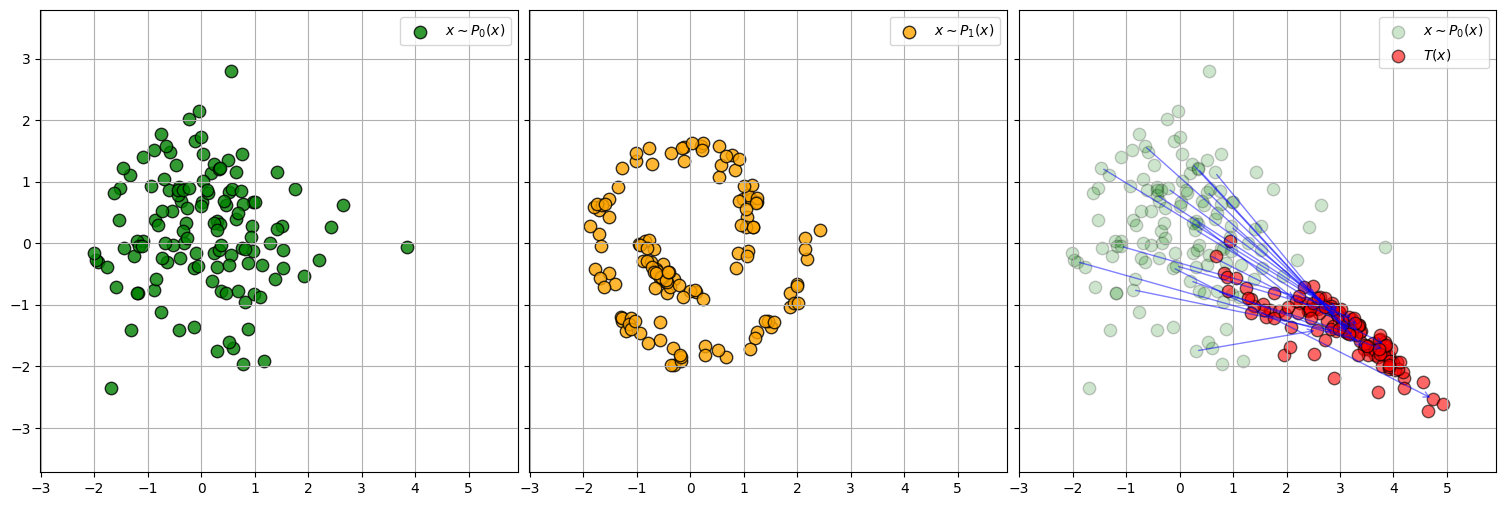

In [116]:
X_fixed = torch.tensor(sample_normal(128), device=DEVICE)
Y_fixed = torch.tensor(sample_swiss(128), device=DEVICE)

X_pred, Y_pred = langevin_sampling(u_model, v_model)
# pca_plot(X_fixed.reshape([X_fixed.shape[0], -1]), Y_fixed.reshape([Y_fixed.shape[0], -1]), X_pred.reshape([X_pred.shape[0], -1]), 128)
pca_plot(X_fixed, Y_fixed, X_pred, 128)

## Training

In [117]:
u_model = MLP_network().to(DEVICE)
v_model = MLP_network().to(DEVICE)
optimizer = torch.optim.Adam(list(u_model.parameters()) + list(v_model.parameters()), lr=params.LR)

In [118]:
DEVICE

'cuda'

In [119]:
X = GaussianDataset(n_samples=1024)
Y = SwissrollDataset(n_samples=1024)

In [120]:
X_s = X.sample(128)
Y_s = Y.sample(128)

In [121]:
def training(u_model, v_model, num_steps=params.NUM_ITERS, val_freq=10, optimizer=optimizer):
    loss_vals = []
    iter_vals = []
    t = tqdm(total=num_steps, desc='', position=0)
    for iteration in range(1, num_steps + 1):
        optimizer.zero_grad()

        x_samples_true = X.sample(params.N_SAMPLES)
        y_samples_true = Y.sample(params.N_SAMPLES)

        x_samples_true = x_samples_true.to(DEVICE)
        y_samples_true = y_samples_true.to(DEVICE)
        x_samples_lg, y_samples_lg = langevin_sampling(u_model, v_model)

        pos_x_out = u_model(x_samples_true)
        pos_y_out = v_model(y_samples_true)
        neg_x_out = u_model(x_samples_lg)
        neg_y_out = v_model(y_samples_lg)

        loss = - pos_y_out.mean() - pos_x_out.mean() + neg_y_out.mean() + neg_x_out.mean()


        loss.backward()
        optimizer.step()

        t.set_description("Loss: {:.2e}".format(loss.item()))
        t.update(1)

        loss_vals.append(loss.item())
        iter_vals.append(iteration)

        if iteration % val_freq == 0:
          u_model.eval()
          v_model.eval()

          clear_output(wait=True)

          plt.plot(iter_vals, loss_vals, '-o', markersize=3, linewidth=1)
          plt.title("Loss")
          plt.xlabel("Iteration")
          plt.ylabel("Loss")

          X_pred, Y_pred = langevin_sampling(u_model, v_model)
          pca_plot(X_s, Y_s, X_pred, n_plot=128)

          plt.tight_layout()

          u_model.train()
          v_model.train()

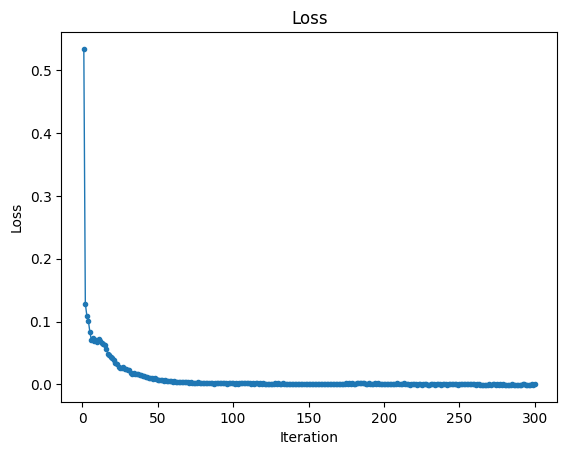

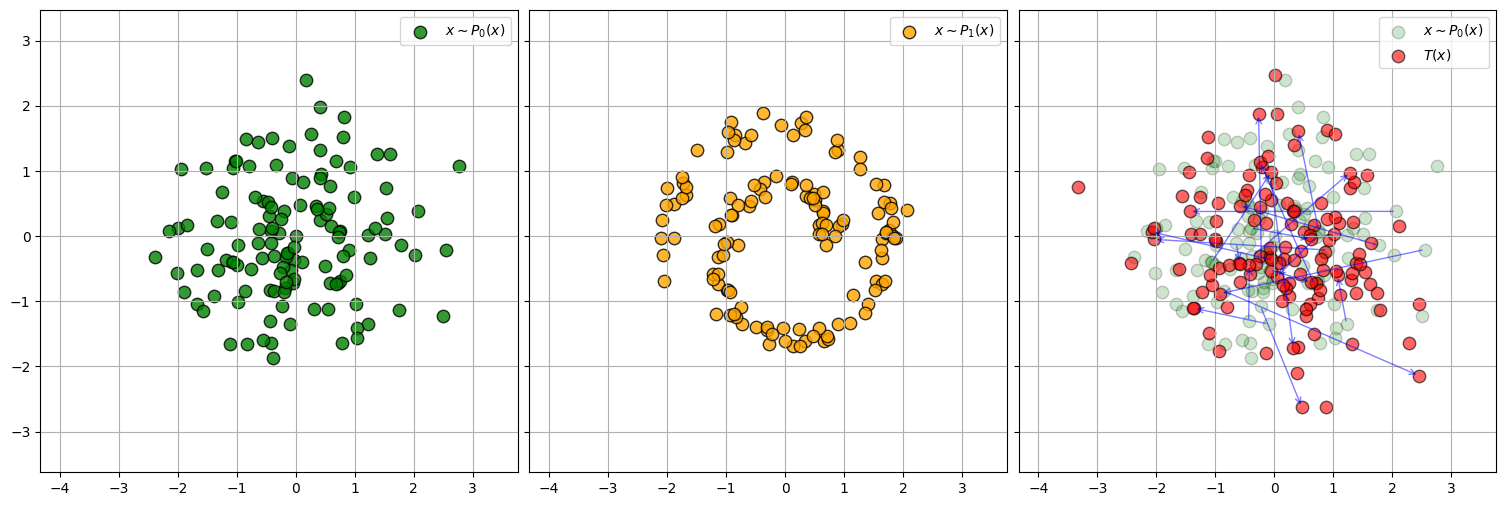

<Figure size 640x480 with 0 Axes>

In [122]:
training(u_model, v_model)